# Plume Probabilities 

In [1]:
from tomosnr import utils
import healpy as hp
import numpy as np
import pandas as pd
import seaborn as sns
import struct
import os
import glob
from scipy.stats import norm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import Normalize, ListedColormap
import multiprocessing as mp
import yaml

### SGLOBE-rani Example

This notebook is an example of calculating the plume probabilities in model SGLOBE-rani.  Depth slices are provided in `data/sglobe/xyz` to show how to convert to HealPix.  SNR measurements are given in `data/snr.zip` for those who want to avoid running `tomosnr`.

#### XYZ to HealPix

Pixelise

In [2]:
Nside = 32

In [5]:
sglobe_path = "data/sglobe"
if not os.path.exists(f"{sglobe_path}/fits"):
    os.mkdir(f"{sglobe_path}/fits")
xyz_files = glob.glob(f"{sglobe_path}/xyz/SGLOBE*")
for file in xyz_files:
    outfile = f"{sglobe_path}/fits/{'.'.join(os.path.basename(file).split('.')[:2]).replace('v.D','.')}"
    utils.xyz2hp(f"{file}", Nside, outfile=outfile)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to

View map

/var/folders/t6/g_v51vw92p98wh69ncgrb0mh0000gn/T/ipykernel_69728/2899444946.py:1: HealpyDeprecationWarning: "verbose" was deprecated in version 1.15.0 and will be removed in a future version. 
  sgl_200 = hp.read_map(f"{sglobe_path}/fits/SGLOBE.0200.fits", verbose=False)


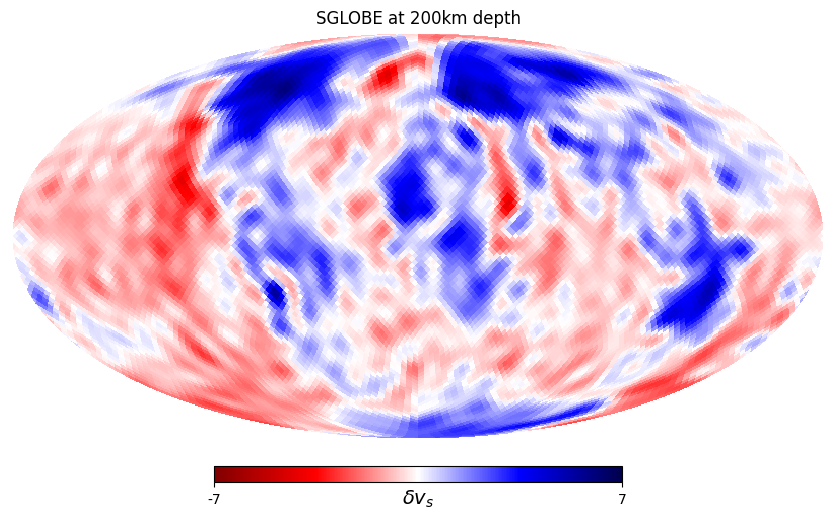

In [6]:
sgl_200 = hp.read_map(f"{sglobe_path}/fits/SGLOBE.0200.fits", verbose=False)
hp.mollview(sgl_200, flip="geo", cmap=cm.seismic_r, title="SGLOBE at 200km depth", min=-7, max=7, unit="$\delta v_s$")

#### Measure SNR

Pre-measured SNRs are given in `data/snr.zip`, so simply unzip

In [ ]:
!cd data; unzip -qq snr.zip

Alternatively you can do the measurements yourself, but this may take a while.  Uncomment the cell below and it will produce snr measurements in `data/sglobe/outputs`.

In [ ]:
# !cd data/sglobe; tomosnr fits/*.fits -s -2 -1

#### Read and plot SNR

In [59]:
def read_snr(tup): # tup = (tile,depth index)
    loc = tup[0]
    dpt = tup[1]
    with open(f'data/snr/{loc}_{dpt}','br') as f:  # Change the path if necessary
        buffer = f.read()
        unpack = struct.unpack('501d',buffer)
    return unpack

For the plumes and elsewheres

In [63]:
locations = yaml.load(open('data/locs.yml'))
plumes = locations['plumes']
elsewheres = locations['elsewheres']
locs = []
for loc in plumes.keys():
    locs.append(loc)
for loc in elsewheres.keys():
    locs.append(loc)

/Users/auggiemarignier/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  """Entry point for launching an IPython kernel.


In [70]:
itrbl = []
for loc in locs:
    for i,dpt in enumerate(depths,1):
        itrbl.append((loc,i))

In [72]:
pool = mp.Pool(4)
out = pool.map(read_snr, itrbl)
pool.close()
pool.join()

In [73]:
snr_local = (pd.DataFrame(out)).transpose()
snr_local.columns = (pd.MultiIndex.from_tuples(itrbl))
snr_local.shape # (number of random maps, number of depths X number of locations)

(501, 616)

In [79]:
def plot_profile(quantity, locations, depths=np.arange(100,2900,100),errors=None, linestyle='-', title=None, 
                 xlim=[-500,500], xlabel=None, c='nipy_spectral',vline=[0],legend=True,ylabels=True,
                 labels=None,leg_loc='best'):
    """
    quantity is a pandas data frame with locations as columns and depths as lows
    errors is a pandas array with the same structure as quantity
    c is a matplotlib colourmap
    """
    ax = plt.gca()
    ax.set_xticks(np.arange(-1,1.5,0.5)*max(abs(np.array(xlim))))
    ax.set_xticks(np.arange(-1,1.25,0.25)*max(abs(np.array(xlim))),minor=True)
    ax.set_yticks(np.arange(0,3000,500))
    ax.set_yticks(np.arange(0,3000,100),minor=True)
    if not ylabels:
        ax.set_yticklabels([])
    cmap = cm.get_cmap(c)
    count_norm = Normalize(vmin=0,vmax=len(locations))
    plt.grid(which='both')
    for i,loc in enumerate(locations):
        x=quantity[loc].values
        g, = plt.plot(x,depths,linestyle,label=loc,color=cmap(count_norm(i)))
        if errors is not None:
            xerr=errors[loc].values
            plt.fill_betweenx(depths, x-2*xerr, x+2*xerr,facecolor=cmap(count_norm(i)), alpha=0.25)
    plt.ylim([max(depths),0])
    for v in vline:
        plt.axvline(v,linewidth=4,color='0.8',zorder=1)
    if ylabels:
        plt.ylabel('Depth (km)')
    plt.xlabel(xlabel)
    plt.xlim(xlim)
    if legend:
        if labels is not None:
            plt.legend(labels,title=title,loc=leg_loc)
        else:
            plt.legend(title=title,loc=leg_loc)
    

In [89]:
snr_local_avs = snr_local.mean()
snr_local_sds = snr_local.std()

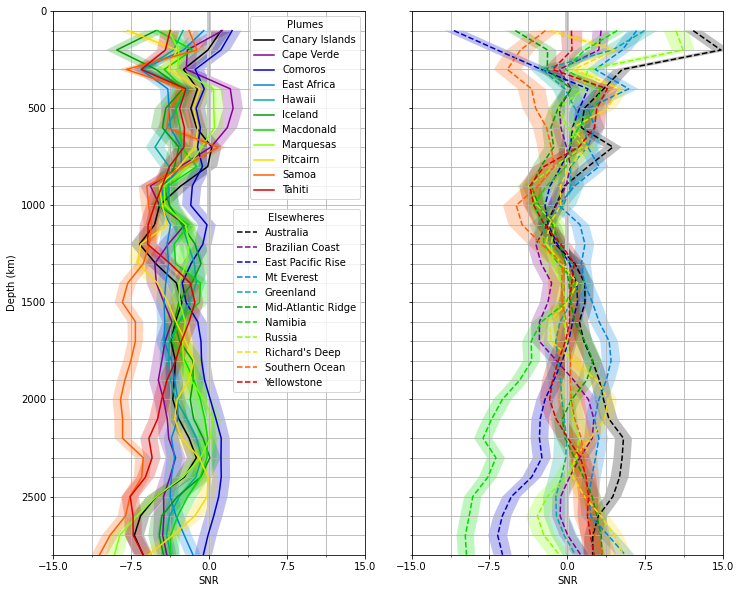

In [90]:
plt.figure(figsize=(12,10))

plt.subplot(121)
labels = ['Canary Islands','Cape Verde','Comoros','East Africa','Hawaii','Iceland','Macdonald','Marquesas','Pitcairn',
          'Samoa','Tahiti']
plot_profile(snr_local_avs,plumes,errors=snr_local_sds,title='Plumes',xlabel='SNR',xlim=[-15,15],labels=labels)

plt.subplot(122)
labels=['Australia','Brazilian Coast','East Pacific Rise','Mt Everest','Greenland','Mid-Atlantic Ridge',
        'Namibia','Russia',"Richard's Deep",'Southern Ocean','Yellowstone']
plot_profile(snr_local_avs,elsewheres,errors=snr_local_sds,title='Elsewheres',
             linestyle='--',xlabel='SNR',xlim=[-15,15],labels=labels,
             ylabels=False, leg_loc=(-0.575,0.3))
plt.subplots_adjust(wspace=0.15)

For the tiled Earth

In [85]:
ntiles = 1105
tiles = [f'8_tile_{i:04d}' for i in range(1,ntiles)]
depths = np.arange(100,2900,100)
itrbl = []
for tile in tiles:
    for i,dpt in enumerate(depths,1):
        itrbl.append((tile,i))

In [86]:
pool = mp.Pool(4)
out = pool.map(read_snr, itrbl)
pool.close()
pool.join()

In [87]:
snr = (pd.DataFrame(out)).transpose()
snr.columns = (pd.MultiIndex.from_tuples(itrbl))
snr.shape # (number of random maps, number of depths X number of tiles)

(501, 30912)

#### Calculate probabilities and confidence maps

In [101]:
def prob_plume_depth(av,sd,thresh=0):
    assert type(av) == pd.core.series.Series
    assert type(sd) == pd.core.series.Series
    assert type(av.index) == pd.core.indexes.multi.MultiIndex
    assert type(sd.index) == pd.core.indexes.multi.MultiIndex
    
    locs = av.index.levels[0]
    depths = av.index.levels[1]
    
    prob = pd.Series(index=av.index)
    for loc in locs:
        for dpt in depths:
            prob[loc,dpt] = norm.cdf(thresh,loc=av[loc,dpt],scale=sd[loc,dpt])
    return prob

def prob_plume(av,sd,thresh=0):
    prob_z = prob_plume_depth(av,sd,thresh)
    locs = prob_z.index.levels[0]
    
    prob = pd.Series(index=locs)
    for loc in locs:
        prob[loc] = prob_z[loc].mean()    
    return prob

def confidence(s2n_avs_tile,s2n_sds_tile):
    avs = pd.Series(index=tiles)
    sds = pd.Series(index=tiles)
    # averages and standard deviations of mixtures
    for tile in tiles:
        avs[tile] = (s2n_avs_tile.loc[tile]).mean()
        sds[tile] = np.sqrt((s2n_avs_tile.loc[tile]**2 + s2n_sds_tile.loc[tile]**2).mean() - avs[tile]**2)
    conf = pd.Series(index=tiles)
    ratios = -avs/sds
    conf[avs<0] = ratios[avs<0]
    return conf

def fill_map(probs,locs,perc=True,Nside=32):
    assert len(probs)==len(locs)
    prob_map = np.full(hp.nside2npix(Nside),hp.UNSEEN)
    for loc in locs:
        mask=hp.read_map(f'../tomosnr/tiles/{loc}.fits',verbose=False) # this path would depend on where Jupyter was launched
        pixels = np.where(mask==0)[0]
        prob_map[pixels] = probs[loc]
    if perc:
        prob_map *= 100
    return prob_map

In [97]:
snr_avs = snr.mean()
snr_sds = snr.std()
probs = prob_plume(snr_avs, snr_sds)
conf = confidence(snr_avs, snr_sds)

/Users/auggiemarignier/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  # Remove the CWD from sys.path while we load stuff.
/Users/auggiemarignier/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/auggiemarignier/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/Users/auggiemarignier/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a fu

In [102]:
prob_map = fill_map(probs, tiles)

/Users/auggiemarignier/anaconda3/lib/python3.7/site-packages/healpy/fitsfunc.py:352: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  "If you are not specifying the input dtype and using the default "


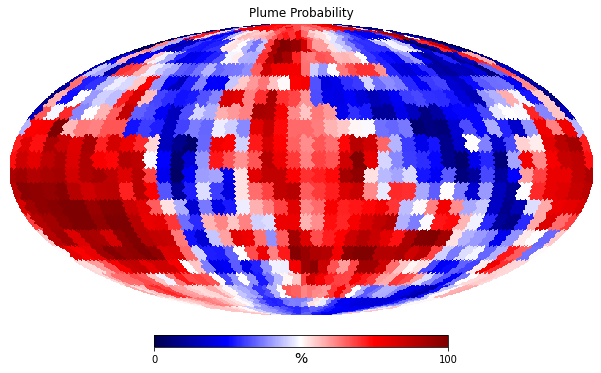

In [105]:
hp.mollview(prob_map, flip="geo", min=0, max=100, title="Plume Probability", cmap=cm.seismic, unit="%")

In [106]:
conf_map = fill_map(conf, tiles)

<Figure size 720x576 with 0 Axes>

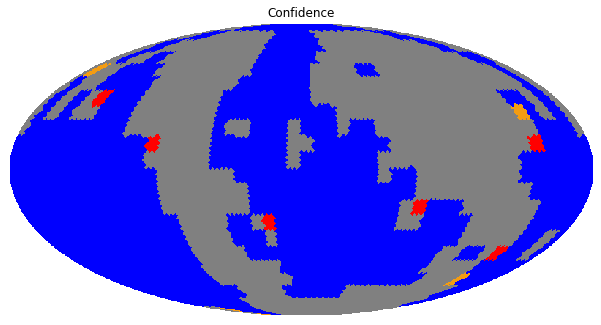

In [112]:
cmap = ListedColormap(['red','#F39C12','blue'])
cmap.set_under('w')
cmap.set_bad('grey')
plt.figure(figsize=(10,8))
hp.mollview(conf_map,flip='geo',title='Confidence',cmap=cmap,min=0,max=3,cbar=False)